# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 39.9 s, sys: 3.89 s, total: 43.8 s
Wall time: 44.4 s


In [5]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

# View

In [6]:
years = X_train.year.unique().tolist()
years

[2019, 2020, 2021, 2022]

In [7]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Run pipeline

In [8]:
X_train.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'timestamp',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
       'lon', 'lat', 'festius', 'festius_sun', 'festius_sun_sat', 'weekend',
       'VALOR_TN_X4', 'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4',
       'ctx1_ctx2_mean', 'ctx1_ctx2_std', 'ctx1_ctx2_ctx3_mean',
       'ctx1_ctx2_ctx3_std', 'ctx1_ctx2_ctx3_ctx4_mean',
       'ctx1_ctx2_ctx3_ctx4_std'],
      dtype='object')

In [10]:
%%time 

columns = X_train.columns[['VALOR' not in i for i in X_train.columns]].to_list()

correlations = np.abs(
    X_train[columns].corr(method='pearson').ctx0
).sort_values(ascending=False)

correlations.to_dict()

CPU times: user 20.7 s, sys: 567 ms, total: 21.3 s
Wall time: 21.3 s


{'ctx0': 1.0,
 'ctx1': 0.9129730514796786,
 'num_docks_available': 0.9055683555185408,
 'num_bikes_available': 0.8893401764262853,
 'ctx1_ctx2_mean': 0.8749838959980545,
 'num_bikes_available_types.mechanical': 0.8419660611344777,
 'ctx1_ctx2_ctx3_mean': 0.8385814221879833,
 'ctx1_ctx2_ctx3_ctx4_mean': 0.8038040173697454,
 'ctx2': 0.798489435958584,
 'ctx3': 0.6970754741833134,
 'ctx4': 0.6062960341913912,
 'lon': 0.263030547218921,
 'num_bikes_available_types.ebike': 0.2176339648798674,
 'ctx1_ctx2_ctx3_ctx4_std': 0.12158394131660635,
 'ctx1_ctx2_ctx3_std': 0.10959527196946488,
 'ctx1_ctx2_std': 0.0907243095776992,
 'lat': 0.07074776190628096,
 'station_id': 0.06967142131249375,
 'timestamp': 0.061366489615208346,
 'year': 0.051252756351171845,
 'dayofyear': 0.04284937914584141,
 'month': 0.042743878873176405,
 'hour': 0.02565808047205957,
 'weekend': 0.019847936776268647,
 'dayofweek': 0.016400115218987096,
 'festius_sun_sat': 0.015699847602472793,
 'festius_sun': 0.01451383074908687

In [11]:
columns_ctx = X_train.columns[['ctx' in i for i in X_train.columns]].to_list()
columns_ctx.remove('ctx0')
print(len(columns_ctx))

columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']
print(len(columns_meteo))

columns_time = ['month', 'dayofyear', 'hour'] # dayofweek, day 
print(len(columns_time))

columns_location = ['lon', 'lat']
print(len(columns_location))

columns_festius = ['festius_sun', 'weekend']
print(len(columns_festius))


10
4
3
2
2


In [12]:
class Config:
    num_attribs0 = ['capacity'] + columns_ctx + columns_meteo
    cat_attribs0 = columns_time
    cat_attribs1 = ['']
    gen_attribs0 = ['station_id'] + columns_festius + columns_location
    target_col = ['ctx0']
    
    seed=42
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [13]:
config=Config()
seed_everything(config.seed)

In [14]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
#             ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [15]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 95 µs, sys: 10 µs, total: 105 µs
Wall time: 112 µs


In [16]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'ctx1_ctx2_mean', 'ctx1_ctx2_std',
                                  'ctx1_ctx2_ctx3_mean', 'ctx1_ctx2_ctx3_std',
                                  'ctx1_ctx2_ctx3_ctx4_mean',
                                  'ctx1_ctx2_ctx3_ctx4_std', 'VALOR_TN_X4',
                                  'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('gen1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['station_id', 'festius_sun', 'weekend', 'lon',
                                  'lat']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['month', 'dayofyear', 'hour'])])

In [53]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

def print_grid_result(result, parm):    
    #plot the results
    plt.figure(figsize=(8, 8))
    plt.title("GridSearchCV",
              fontsize=16)

    plt.xlabel("residual_threshold")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(results[parm].data.min(),results[parm].data.max())


    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[parm].data, dtype=float)

    for sample, style in (('train', '--'), ('test', '-')):

        sample_score_mean = (-results['mean_%s_score' % (sample)])
        sample_score_std = (results['std_%s_score' % (sample)])

        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0)
        ax.plot(X_axis, sample_score_mean, style,
                alpha=1 if sample == 'test' else 0.7,
                label="(%s)" % ( sample))

    best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
    best_score =  (-results['mean_test_score' ][best_index])

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
            linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()


In [18]:
[months.remove(x) for x in [6,7,8,9,10]]

[None, None, None, None, None]

In [19]:
years, months

([2019, 2020, 2021, 2022], [1, 2, 3, 4, 5, 11, 12])

In [20]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2021, 2022], months, True)


train
X (4108638, 34) X_prepared: (4108638, 23) y:  (4108638,)
val
X (1016614, 34) X_prepared: (1016614, 23) y:  (1016614,)
test
X (358887, 34) X_prepared: (358887, 23) y:  (358887,)


In [21]:
import gc

gc.collect()

72

# Prediction

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [23]:
lin_reg = LinearRegression(n_jobs=5)

In [24]:
ridge_reg = Ridge(alpha=.3, random_state=config.seed)

In [25]:
lasso_reg = Lasso(alpha=0.01, random_state=config.seed)

In [26]:
# Elastic net regression is a linear regression model
# reduce overfitting
# and select relevant features
# uses a penalty term to shrink the coefficients of the predictors.
# combination of the l1-norm (absolute value) and the l2-norm (square) of the coefficients

# The main difference between elastic net and lasso or ridge is that elastic net has an additional parameter called lambda, 
# which controls the balance between the l1-norm and the l2-norm penalties. When lambda is zero, elastic net is equivalent to lasso.
# When lambda is one, elastic net is equivalent to ridge. When lambda is between zero and one, elastic net is a compromise between 
# lasso and ridge. This allows elastic net to adapt to different situations and data sets.

elasticNet_reg = ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=config.seed) 

### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.1s finished



  model test
Scores: [-0.11166485 -0.11151498 -0.1136203  -0.11551754 -0.11575034]
Mean: -0.1136136014254431
Standard deviation: 0.001810663797812048

Training time: 0.094 s
----- EVALUATION ON VAL SET ------
MSE: 0.012905136789047601
RMSE 0.11360077811814319
MAE: 0.07454549632332041
R^2:  0.8237404277743079



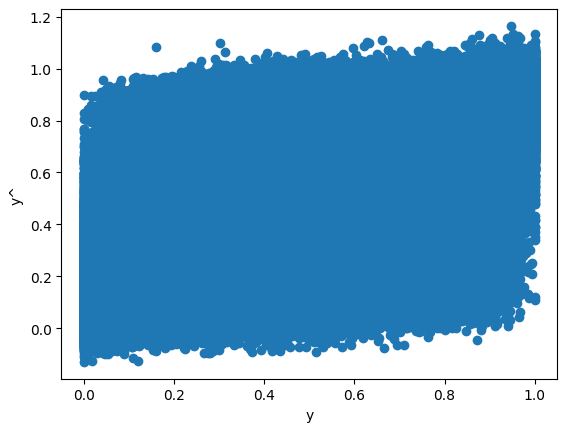


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941967980479427
RMSE 0.09456197957149283
MAE: 0.05939220089304241
R^2:  0.8710442988582237



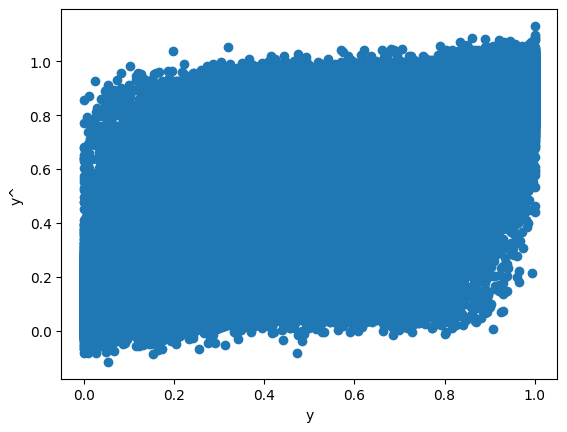


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933886181893099
RMSE 0.11804188316819204
MAE: 0.07893765816828933
R^2:  0.8094805357275153



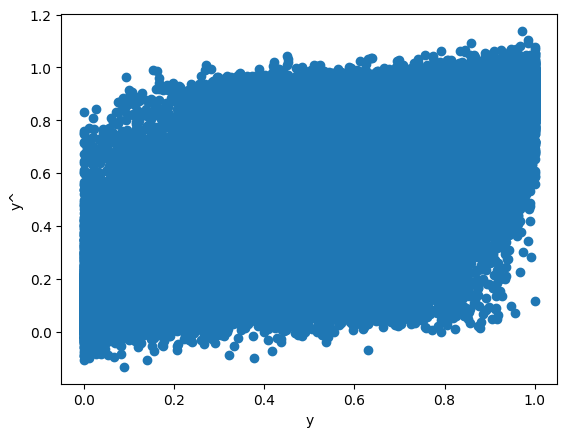

CPU times: user 18.8 s, sys: 18.5 s, total: 37.4 s
Wall time: 20.3 s


{'train': mse_t     0.012905
 rmse_t    0.113601
 mae_t     0.074545
 r2_t       0.82374
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059392
 r2_t      0.871044
 mse_v     0.013934
 rmse_v    0.118042
 mae_v     0.078938
 r2_v      0.809481
 dtype: object}

In [27]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.013319
#  rmse_t    0.115408
#  mae_t     0.076947
#  r2_t      0.805179
#  dtype: object,
#  'test': mse_t     0.009486
#  rmse_t    0.097396
#  mae_t      0.06385
#  r2_t      0.854869
#  mse_v     0.014026
#  rmse_v    0.118431
#  mae_v     0.079915
#  r2_v      0.808233
#  dtype: object}

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.9s finished



  model test
Scores: [-0.11558634 -0.11541634 -0.11693974 -0.11855586 -0.11879798]
Mean: -0.11705925267850711
Standard deviation: 0.0014244941427146323

Training time: 0.095 s
----- EVALUATION ON VAL SET ------
MSE: 0.013699732716607986
RMSE 0.11704585732356351
MAE: 0.07924787345385471
R^2:  0.8128877618496093



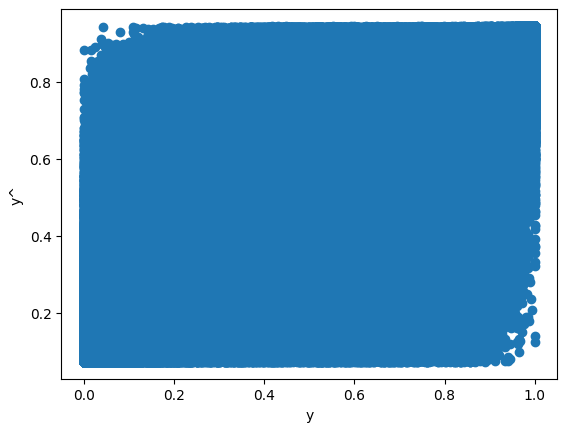


Training time: 0.028 s
----- EVALUATION ON VAL SET ------
MSE: 0.009821850766853117
RMSE 0.09910525095499792
MAE: 0.06555531868412684
R^2:  0.8583551568385811



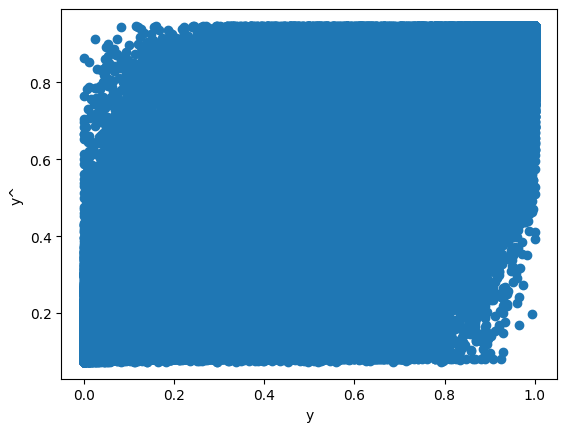


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.01472961113720383
RMSE 0.121365609367744
MAE: 0.08339452832727937
R^2:  0.7986005062644462



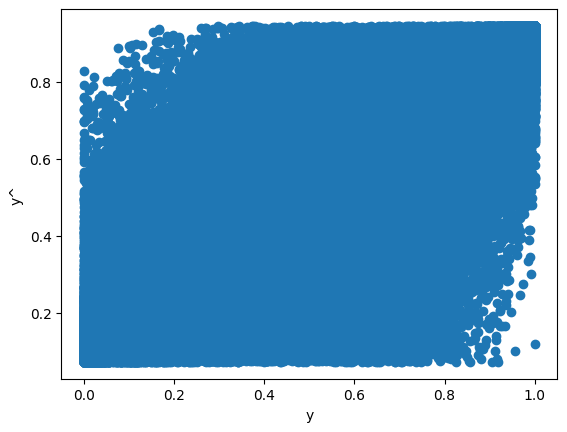

CPU times: user 13.2 s, sys: 5.49 s, total: 18.7 s
Wall time: 12.7 s


{'train': mse_t       0.0137
 rmse_t    0.117046
 mae_t     0.079248
 r2_t      0.812888
 dtype: object,
 'test': mse_t     0.009822
 rmse_t    0.099105
 mae_t     0.065555
 r2_t      0.858355
 mse_v      0.01473
 rmse_v    0.121366
 mae_v     0.083395
 r2_v      0.798601
 dtype: object}

In [28]:
%%time 

test_model_train_val_test(
    lasso_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished



  model test
Scores: [-0.11166495 -0.11151506 -0.11362028 -0.11551743 -0.11575026]
Mean: -0.11361359928184152
Standard deviation: 0.00181058094851334

Training time: 0.097 s
----- EVALUATION ON VAL SET ------
MSE: 0.012905136800137594
RMSE 0.11360077816695445
MAE: 0.07454537419775233
R^2:  0.8237404276228397



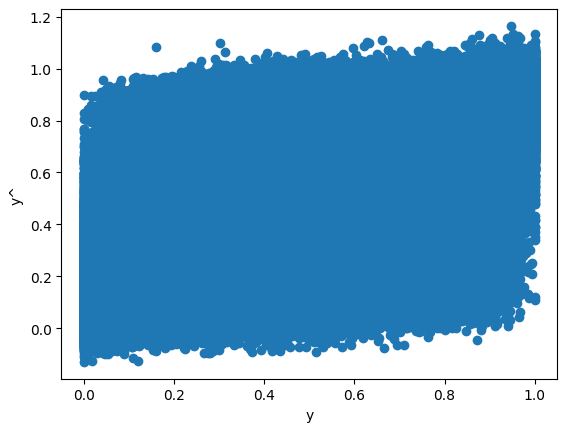


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.008941986551667816
RMSE 0.0945620777672943
MAE: 0.0593925094078251
R^2:  0.8710440310356788



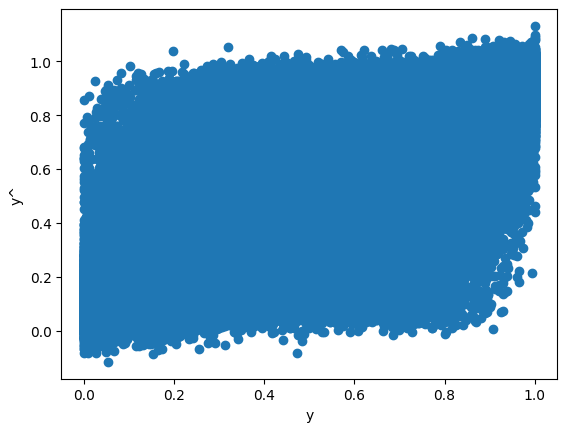


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.013933883772851468
RMSE 0.11804187296400998
MAE: 0.07893751378190234
R^2:  0.8094805686665902



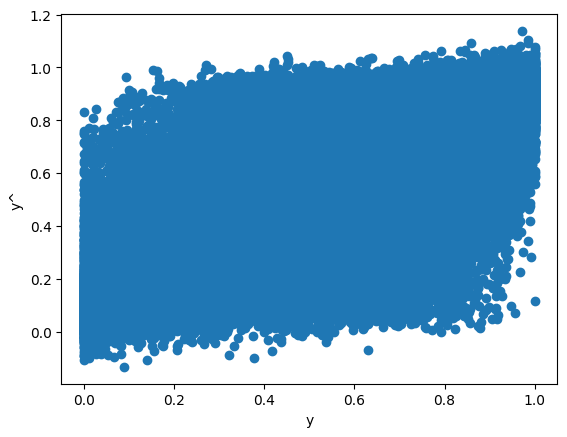

CPU times: user 10.9 s, sys: 4.65 s, total: 15.6 s
Wall time: 10.3 s


{'train': mse_t     0.012905
 rmse_t    0.113601
 mae_t     0.074545
 r2_t       0.82374
 dtype: object,
 'test': mse_t     0.008942
 rmse_t    0.094562
 mae_t     0.059393
 r2_t      0.871044
 mse_v     0.013934
 rmse_v    0.118042
 mae_v     0.078938
 r2_v      0.809481
 dtype: object}

In [29]:
%%time 

test_model_train_val_test(
    ridge_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.3s remaining:   13.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    9.5s finished



  model test
Scores: [-0.11402518 -0.11387279 -0.11560933 -0.1173843  -0.11764193]
Mean: -0.11570670602735504
Standard deviation: 0.0015974769697069742

Training time: 0.103 s
----- EVALUATION ON VAL SET ------
MSE: 0.013384990745667447
RMSE 0.1156935207592346
MAE: 0.07683718048833174
R^2:  0.8171865372958744



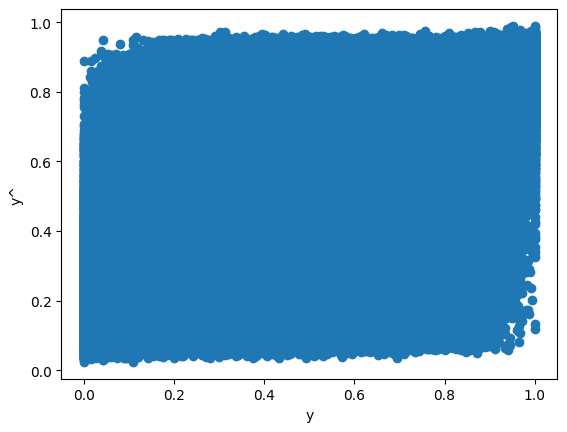


Training time: 0.025 s
----- EVALUATION ON VAL SET ------
MSE: 0.009485369965622398
RMSE 0.09739286403850335
MAE: 0.06284686141119913
R^2:  0.8632076812200348



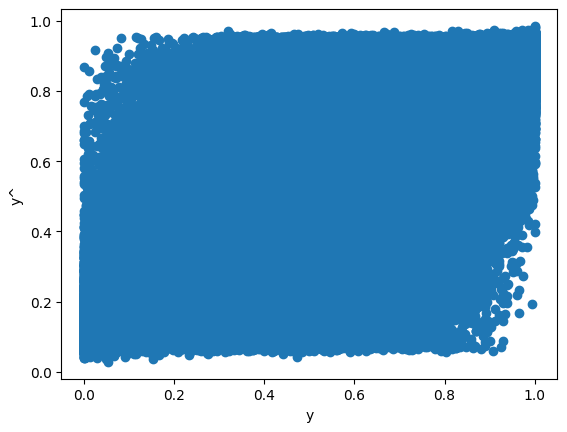


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014418843773090384
RMSE 0.12007849005167572
MAE: 0.08114910192830199
R^2:  0.802849660516991



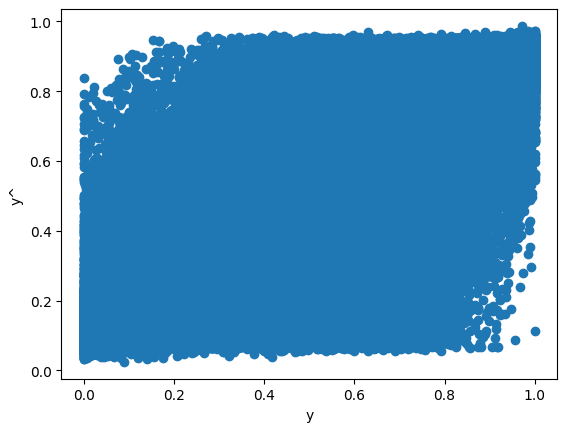

CPU times: user 35.3 s, sys: 10.3 s, total: 45.6 s
Wall time: 19.8 s


{'train': mse_t     0.013385
 rmse_t    0.115694
 mae_t     0.076837
 r2_t      0.817187
 dtype: object,
 'test': mse_t     0.009485
 rmse_t    0.097393
 mae_t     0.062847
 r2_t      0.863208
 mse_v     0.014419
 rmse_v    0.120078
 mae_v     0.081149
 r2_v       0.80285
 dtype: object}

In [30]:
%%time 

test_model_train_val_test(
    elasticNet_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


## KNN3
### Not ideal to store and sort large data.
https://www.kaggle.com/general/352216

## SVM 
### SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. 
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python#advantages

## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
%%time 

# define model 
tree_reg = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=12, 
    random_state=config.seed
)


CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 23.4 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   51.2s remaining:  1.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   51.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   51.9s finished



  model test
Scores: [-0.10715108 -0.10703776 -0.10914086 -0.11120652 -0.11138029]
Mean: -0.1091833029094543
Standard deviation: 0.0018791105968966383

Training time: 0.439 s
----- EVALUATION ON VAL SET ------
MSE: 0.011561245740577038
RMSE 0.10752323349200878
MAE: 0.06970079963488081
R^2:  0.8420954181315112



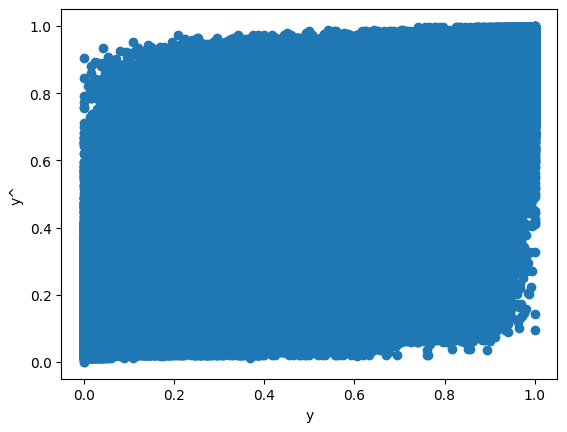


Training time: 0.104 s
----- EVALUATION ON VAL SET ------
MSE: 0.00873883351059196
RMSE 0.09348172821782855
MAE: 0.057321347108693216
R^2:  0.8739737823955821



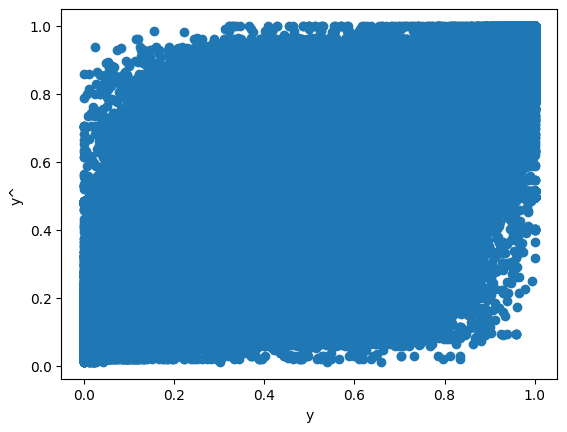


Testing time: 0.04 s
----- EVALUATION ON VAL SET ------
MSE: 0.012954061600047589
RMSE 0.11381591101444292
MAE: 0.07558981712914724
R^2:  0.8228777783902838



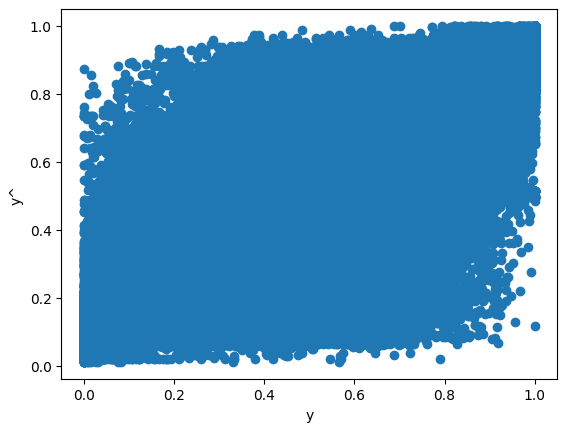

CPU times: user 1min 5s, sys: 1.85 s, total: 1min 7s
Wall time: 1min 57s


{'train': mse_t     0.011561
 rmse_t    0.107523
 mae_t     0.069701
 r2_t      0.842095
 dtype: object,
 'test': mse_t     0.008739
 rmse_t    0.093482
 mae_t     0.057321
 r2_t      0.873974
 mse_v     0.012954
 rmse_v    0.113816
 mae_v      0.07559
 r2_v      0.822878
 dtype: object}

In [57]:
%%time 

test_model_train_val_test(
    tree_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


### Testing each month

In [58]:
%%time 

result = do_test_per_month(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=12, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021, 2022],
    months
)

  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 49.2 s, sys: 15.8 ms, total: 49.3 s
Wall time: 49.3 s


In [59]:
result

,order_,mae_t_test,mae_t_train,mae_v_test,mae_v_train,mse_t_test,mse_t_train,mse_v_test,mse_v_train,r2_t_test,r2_t_train,r2_v_test,r2_v_train,rmse_t_test,rmse_t_train,rmse_v_test,rmse_v_train
0,0,0.062646,0.058257,0.084839,NaN,0.011217,0.008772,0.016764,NaN,0.828368,0.87452,0.770789,NaN,0.105911,0.093658,0.129475,NaN
1,1,0.065679,0.063789,0.083888,NaN,0.014095,0.009967,0.016543,NaN,0.813384,0.879183,0.77381,NaN,0.118724,0.099835,0.128618,NaN
2,2,0.067123,0.064489,0.083781,NaN,0.014349,0.010224,0.016351,NaN,0.812553,0.877989,0.77643,NaN,0.119788,0.101114,0.127871,NaN
3,3,0.062667,0.062931,0.083618,NaN,0.011436,0.009934,0.016268,NaN,0.853648,0.882984,0.777566,NaN,0.106938,0.09967,0.127546,NaN
4,4,0.063296,0.066703,0.083191,NaN,0.011295,0.010625,0.016288,NaN,0.85921,0.880399,0.777293,NaN,0.106279,0.103078,0.127624,NaN
5,5,0.06272,0.066411,0.082415,NaN,0.010774,0.010231,0.01586,NaN,0.843745,0.855747,0.783147,NaN,0.103796,0.101146,0.125936,NaN
6,6,0.060898,0.060983,0.083967,NaN,0.010255,0.008814,0.01653,NaN,0.83974,0.860764,0.77398,NaN,0.101266,0.093882,0.12857,NaN
7,7,0.063002,0.064226,0.085723,NaN,0.010914,0.009739,0.016414,NaN,0.815068,0.840329,0.775574,NaN,0.104468,0.098686,0.128116,NaN
8,8,0.070682,0.072424,0.084653,NaN,0.013344,0.011753,0.01665,NaN,0.810305,0.834687,0.772343,NaN,0.115518,0.108412,0.129035,NaN
9,9,0.071045,0.070797,0.084096,NaN,0.01297,0.011292,0.015953,NaN,0.80046,0.826308,0.781868,NaN,0.113886,0.106263,0.126307,NaN


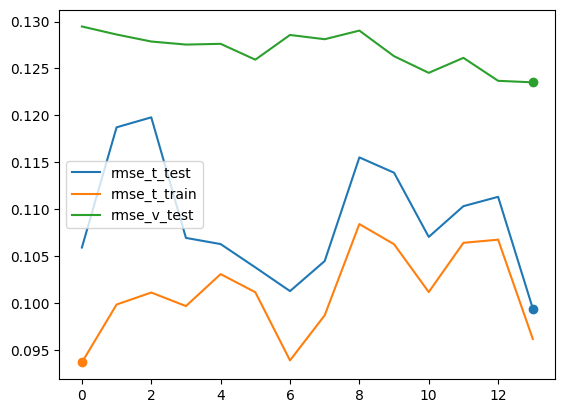

In [60]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [61]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.091301
# rmse_t_train     0.09943
# rmse_v_test     0.119586
# dtype: object

rmse_t_test     0.099411
rmse_t_train    0.093658
rmse_v_test      0.12352
dtype: object

In [62]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.867151
# r2_t_train    0.850738
# r2_v_test     0.804474
# dtype: object

r2_t_test      0.85921
r2_t_train    0.882984
r2_v_test     0.791387
dtype: object

### Testing combination of three consecutive months

In [63]:
%%time

result = do_test_per_month_combos(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=12, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/14 [00:00<?, ?months/s]

CPU times: user 2min 18s, sys: 4.13 ms, total: 2min 18s
Wall time: 2min 18s


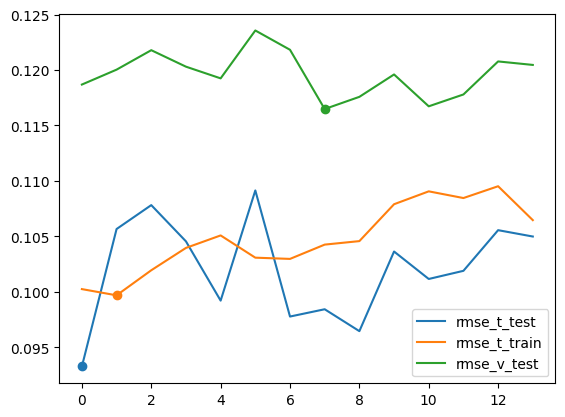

In [64]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [65]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.093224
# rmse_t_train    0.106735
# rmse_v_test     0.115668
# dtype: object

rmse_t_test     0.093267
rmse_t_train    0.099683
rmse_v_test     0.116482
dtype: object

In [66]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.864013
# r2_t_train     0.83079
# r2_v_test     0.817077
# dtype: object

r2_t_test     0.876389
r2_t_train    0.874299
r2_v_test     0.814484
dtype: object

[CV] END .................................................... total time=  49.6s
[CV] END .................................................... total time=  50.3s
[CV] END .................................................... total time=  50.7s
[CV] END .................................................... total time=  50.8s
[CV] END .................................................... total time=  50.9s


### Fine tuning parameters

In [43]:
# define model 
tree_reg = DecisionTreeRegressor(criterion='friedman_mse', random_state=config.seed)

param_grid = [
    {
        'max_depth':[8, 9, 10, 11, 12, 13]
    }
]

grid_search = GridSearchCV(
    tree_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [44]:
grid_search.fit(X_train_prepared, y_train_prepared)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................max_depth=8; total time=  34.1s
[CV] END ........................................max_depth=8; total time=  34.5s
[CV] END ........................................max_depth=8; total time=  34.4s
[CV] END ........................................max_depth=8; total time=  34.6s
[CV] END ........................................max_depth=8; total time=  34.5s
[CV] END ........................................max_depth=9; total time=  37.5s
[CV] END ........................................max_depth=9; total time=  38.4s
[CV] END ........................................max_depth=9; total time=  38.7s
[CV] END ........................................max_depth=9; total time=  37.0s
[CV] END ........................................max_depth=9; total time=  36.9s
[CV] END .......................................max_depth=10; total time=  39.2s
[CV] END .......................................m

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                             random_state=42),
             param_grid=[{'max_depth': [8, 9, 10, 11, 12, 13]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [45]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'max_depth': 12}


In [46]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


DecisionTreeRegressor(criterion='friedman_mse', max_depth=12, random_state=42)

In [47]:
print("Best Score")
-grid_search.best_score_

Best Score


0.1091833029094543

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.11123987737024602 {'max_depth': 8}
0.11045368198067747 {'max_depth': 9}
0.1098171813435489 {'max_depth': 10}
0.1093731745256125 {'max_depth': 11}
0.1091833029094543 {'max_depth': 12}
0.10932679581082005 {'max_depth': 13}


In [49]:
results = grid_search.cv_results_

In [51]:
results

{'mean_fit_time': array([34.35725217, 37.64591603, 39.25999374, 41.98958454, 44.86360693,
        47.24010792]),
 'std_fit_time': array([0.1880694 , 0.72855779, 0.34509869, 0.18553055, 0.22876044,
        0.42666296]),
 'mean_score_time': array([0.06127453, 0.0679986 , 0.07609491, 0.0830843 , 0.09148617,
        0.09783635]),
 'std_score_time': array([0.00079588, 0.00108344, 0.00070637, 0.00067302, 0.00170417,
        0.00057703]),
 'param_max_depth': masked_array(data=[8, 9, 10, 11, 12, 13],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10},
  {'max_depth': 11},
  {'max_depth': 12},
  {'max_depth': 13}],
 'split0_test_score': array([-0.10931604, -0.10846211, -0.10779018, -0.10734557, -0.10715108,
        -0.10730265]),
 'split1_test_score': array([-0.10916636, -0.10835287, -0.10767338, -0.10727481, -0.10703776,
        -0.10723041]),
 'split2_test_scor

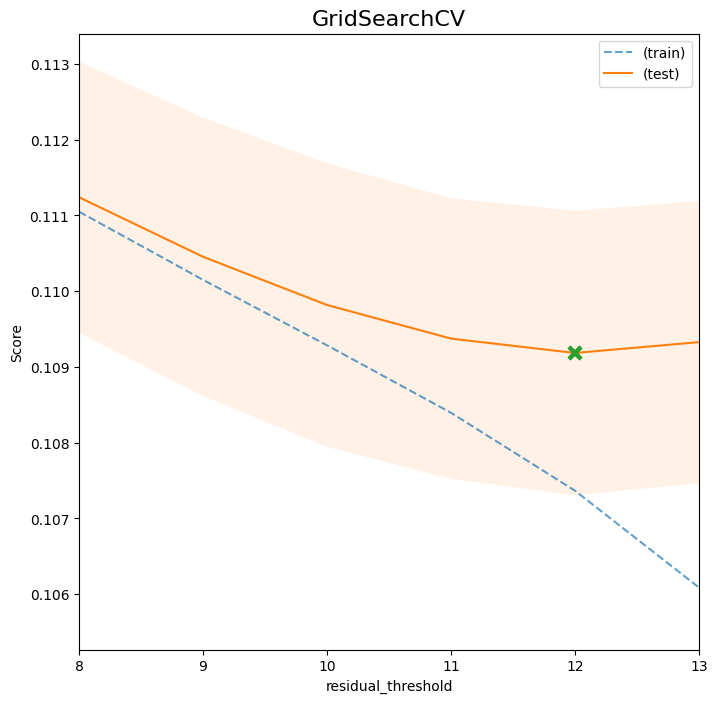

In [54]:
print_grid_result(results, 'param_max_depth')

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
%%time 

# define used regressor
forest=RandomForestRegressor(n_estimators=100,
                             max_depth=12,
                             criterion='friedman_mse',
                             n_jobs=10,
                             random_state=config.seed
                            )

CPU times: user 0 ns, sys: 122 µs, total: 122 µs
Wall time: 130 µs


### Train and test, validate model

In [ ]:
%%time

test_model_train_val_test(
    forest, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


### Testing each month

In [ ]:
%%time 

result = do_test_per_month(
    RandomForestRegressor(n_estimators=100, max_depth=12, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021, 2022],
    months
)

In [ ]:
result

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.091301
# rmse_t_train     0.09943
# rmse_v_test     0.119586
# dtype: object

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.867151
# r2_t_train    0.850738
# r2_v_test     0.804474
# dtype: object

### Testing combination of three consecutive months

In [ ]:
%%time

result = do_test_per_month_combos(
    RandomForestRegressor(n_estimators=100, max_depth=12, criterion='friedman_mse', n_jobs=10, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.093224
# rmse_t_train    0.106735
# rmse_v_test     0.115668
# dtype: object

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.864013
# r2_t_train     0.83079
# r2_v_test     0.817077
# dtype: object

### Fine tuning parameters

In [ ]:
# define model 
forest_reg = DecisionTreeRegressor(criterion='friedman_mse', n_jobs=10, random_state=config.seed)

param_grid = [
    {
        'max_depth':[9, 10, 11, 12, 13, 14],
        'n_estimators':[80, 100, 120, 140]
    }
]

grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [ ]:
grid_search.fit(X_train_prepared[], y_train_prepared)

In [ ]:

print("the best parameters are:")
print(grid_search.best_params_)


In [ ]:
print("the best trained model:")
grid_search.best_estimator_

In [ ]:
print("Best Score")
-grid_search.best_score_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

In [ ]:
results = grid_search.cv_results_

In [ ]:
results

In [ ]:
print_grid_result(results, 'param_max_depth')

## Gradiend Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
%%time 

boosting = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=11, 
    loss='squared_error',
    criterion='friedman_mse',
    random_state=config.seed,
    verbose=2,
    warm_start=True
)


### Train and test, validate model

In [ ]:
%%time 

test_model_train_val_test(
    boosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

### Testing each month

In [ ]:
%%time 

result = do_test_per_month(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=0
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    months
)

# CPU times: user 38min 55s, sys: 196 ms, total: 38min 55s
# Wall time: 38min 54s

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

### Testing combination of three consecutive months

In [ ]:
%%time 

result = do_test_per_month_combos(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=2
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2021,2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [ ]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

In [ ]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

### Fine tuning parameters

In [ ]:
# define model 
boosting = GradientBoostingRegressor(loss='squared_error', criterion='friedman_mse', random_state=config.seed)

param_grid = [
    {
        'max_depth':[9, 10, 11, 12, 13, 14],
        'n_estimators':[80, 100, 120, 140]
    }
]

grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [ ]:
grid_search.fit(X_train_prepared[], y_train_prepared)

In [ ]:

print("the best parameters are:")
print(grid_search.best_params_)


In [ ]:
print("the best trained model:")
grid_search.best_estimator_

In [ ]:
print("Best Score")
-grid_search.best_score_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

In [ ]:
results = grid_search.cv_results_

In [ ]:
results

In [ ]:
print_grid_result(results, 'param_max_depth')

## HistGradientBoostingRegressor

# Generate Sample

In [ ]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [ ]:
sample_data

## apply pipeline

In [ ]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

## Prediction 

In [ ]:
%%time 

model = forest

In [ ]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 1

In [ ]:
name

In [ ]:
yhat = model.predict(X_sample_prepared)

In [ ]:
yhat.shape

In [ ]:
sample_data['percentage_docks_available'] = yhat

In [ ]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')

In [ ]:

aux = X_test[X_test.month.isin([3]) & X_test.station_id.isin(sample_data.station_id.unique())][['station_id', 'year', 'month','day','hour', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']]


In [ ]:
sample_data = sample_data.merge(aux,
                                on=['station_id','month','day','hour'],
                                how='left')

In [ ]:
sample_data

In [ ]:

sample_data[['station_id', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx0', 'ctx1_x', 'ctx1_y', 'ctx4_x', 'ctx4_y', 'ctx3_x', 'ctx3_y', 'ctx2_x', 'ctx2_y']]



In [ ]:
np.abs(sample_data['percentage_docks_available'] - sample_data['ctx0']).plot()